In [1]:
import numpy as np 
import pandas as pd 
import os
import cv2
import numpy as np
import shutil
import tensorflow as tf
from sklearn import preprocessing
from keras.preprocessing import image
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, accuracy_score
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import f1_score
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from glob import glob

In [2]:
base_dir = '/content/drive/MyDrive/Thesis_Paper/CNN/'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'test')

In [3]:
BATCH_SIZE = 5
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 400 files belonging to 2 classes.


In [4]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 100 files belonging to 2 classes.


In [5]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [6]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 16
Number of test batches: 4


In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [8]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

In [9]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [10]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [11]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [12]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(5, 5, 5, 1280)


In [13]:
base_model.trainable = False

In [14]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

In [15]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(5, 1280)


In [16]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(5, 1)


In [17]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [18]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [19]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [20]:
len(model.trainable_variables)

2

In [21]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

16/16 [==============================] - 3s 29ms/step - loss: 0.7574 - accuracy: 0.5250


In [22]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.76
initial accuracy: 0.52


In [24]:
history = model.fit(train_dataset,
                    epochs=20,
                    validation_data=validation_dataset)

Epoch 1/20
80/80 [==============================] - 7s 84ms/step - loss: 0.4971 - accuracy: 0.7575 - val_loss: 0.5540 - val_accuracy: 0.7125
Epoch 2/20
80/80 [==============================] - 8s 86ms/step - loss: 0.4860 - accuracy: 0.7600 - val_loss: 0.5133 - val_accuracy: 0.7250
Epoch 3/20
80/80 [==============================] - 7s 77ms/step - loss: 0.4827 - accuracy: 0.7800 - val_loss: 0.5388 - val_accuracy: 0.7125
Epoch 4/20
80/80 [==============================] - 7s 77ms/step - loss: 0.4718 - accuracy: 0.7425 - val_loss: 0.5384 - val_accuracy: 0.7250
Epoch 5/20
80/80 [==============================] - 7s 79ms/step - loss: 0.4300 - accuracy: 0.7900 - val_loss: 0.5235 - val_accuracy: 0.7625
Epoch 6/20
80/80 [==============================] - 7s 77ms/step - loss: 0.4703 - accuracy: 0.7625 - val_loss: 0.5574 - val_accuracy: 0.6875
Epoch 7/20
80/80 [==============================] - 7s 78ms/step - loss: 0.4536 - accuracy: 0.7725 - val_loss: 0.5152 - val_accuracy: 0.7500
Epoch 8/20
80

Text(0.5, 1.0, 'Training and Validation Accuracy (MobileNetV2)')

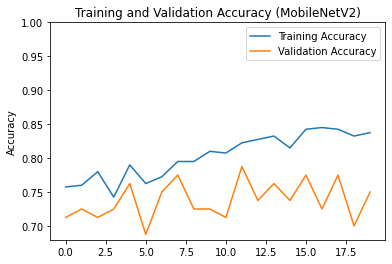

In [52]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='upper right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy (MobileNetV2)')

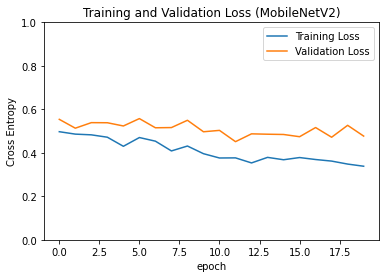

In [33]:
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss (MobileNetV2)')
plt.xlabel('epoch')
plt.show()

In [39]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

4/4 [==============================] - 1s 63ms/step - loss: 0.4875 - accuracy: 0.7000
Test accuracy : 0.699999988079071
